In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Libraries
import os
import pickle
import random
import math

from numpy import exp
from tqdm import tqdm 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


In [3]:
class Data:
    def __init__(self):
        self.Xval= None
        self.yval= None

    def preprocessing(self, data):
      feature_list = []
      for i in range(0, len(data)):
          img = data["Image"][i].convert("L")
          img = np.resize(img, (28,28))
          flat_list = []
          for sublist in img:
              for item in sublist:
                  flat_list.append(item/255)
          feature_list.append(flat_list)
      temp_data = pd.DataFrame(feature_list)
      return temp_data
    
    def loadData(self):
        # train_data = pickle.load(open("/content/drive/MyDrive/DL_A2_P1/train_set.pkl", "rb" ))
        train_data = pickle.load(open("/content/drive/MyDrive/Shared DL Assignment Folder/A2 - Part 1/train_set.pkl", "rb" ))
        y_train = np.array(train_data["Labels"])
        # val_data = pickle.load(open("/content/drive/MyDrive/DL_A2_P1/val_set.pkl", "rb" ))
        val_data = pickle.load(open("/content/drive/MyDrive/Shared DL Assignment Folder/A2 - Part 1/val_set.pkl", "rb" ))
        y_val = np.array(val_data["Labels"])
        X_train = self.preprocessing(train_data)
        X_val = self.preprocessing(val_data)
        self.Xval=X_val
        self.yval=y_val
        return X_train, X_val, y_train, y_val
    
    def subSample(self,X_train, y_train):
        return train_test_split(X_train, y_train, stratify=y_train, test_size=0.8)
    

In [4]:
class MLPClassifier:
    def __init__(self, layers, learning_rate = 1e-5, activation_function = 'relu', 
                 optimizer = 'gradient_descent', weight_init = 'random', 
                 regularization = 'l2', batch_size = 64, num_epochs=50, dropouts=0.1,lm=0.2 ,**kwargs):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.weight_init = weight_init
        self.regularization = regularization
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.dropouts = dropouts

        self.weights = None
        self.bias = None
        self.Xval= None
        self.yval= None

        self.xx=None
        self.yy=None
        self.mt=None
        self.epsilon=1e-8
        self.grad_nptel = []
        self.learning_matrix = []
        self.epsilon_matrix = []

        self.lm=lm
    
    def activation(self, x_i):
        x_i = np.array(x_i)
        if self.activation_function == 'sigmoid':
            return 1/(1 + np.exp(-x_i)) 
        
        elif self.activation_function == 'tanh':
            return np.tanh(x_i)

        elif self.activation_function == 'relu':
            t = []
            for i in x_i:
              t.append(max(0, i))
            return t
        
    def activationGradient(self,x_i):
        x_i = np.array(x_i)
        if self.activation_function == 'sigmoid':
            sigmoid = self.activation(x_i)
            return sigmoid*(1-sigmoid)
    
        elif self.activation_function == 'tanh':
            return 1 - self.activation(x_i)**2

        elif self.activation_function == 'relu':
            if x_i>=0:
              return 1
            else:
              return 0

    def softmax(self,x_i):
        e = exp(x_i)
        return list(e / e.sum())

    def l2Loss(self, output_list, y):
        error_sum = 0
        squared_sum=0
        l2=0
        for i in range(0, len(output_list)):
          error_sum -= math.log(output_list[i][y[i]])
        squared_sum+=np.sum(np.square(self.weights[0]))
        squared_sum+=np.sum(np.square(self.weights[1]))
        l2=(squared_sum*self.lm)/2
        l2+=(error_sum/len(output_list))
        # print(l2)
        return l2
        
    def l1Loss(self, output_list, y):
        error_sum = 0
        squared_sum=0
        l1=0
        for i in range(0, len(output_list)):
          error_sum -= math.log(output_list[i][y[i]])
        squared_sum+=np.sum(np.absolute(self.weights[0]))
        squared_sum+=np.sum(np.absolute(self.weights[1]))
        l1=(squared_sum*self.lm)
        l1+=(error_sum/len(output_list))
        # print(l2)
        return l1

    def regularize(self, output_list, y):
        if self.regularization=="l2":
          return self.l2Loss(output_list, y)
        elif self.regularization=="l1":
          return self.l1Loss(output_list, y)
        else:
          return self.error(output_list, y)
    
    def xavier(self):
        self.weights = [[], []]
        for i in range(0, self.layers[1]):
            self.weights[0].append([])
            for j in range(0, self.layers[0]):
                self.weights[0][i].append(np.random.rand()/math.sqrt(self.layers[0]))
        for i in range(0, self.layers[2]):
            self.weights[1].append([])
            for j in range(0, self.layers[1]):
                self.weights[1][i].append(np.random.rand()/math.sqrt(self.layers[1]))

    def he(self):
        self.weights = [[], []]
        for i in range(0, self.layers[1]):
            self.weights[0].append([])
            for j in range(0, self.layers[0]):
                self.weights[0][i].append(np.random.rand()*math.sqrt(2/self.layers[0]))
        for i in range(0, self.layers[2]):
            self.weights[1].append([])
            for j in range(0, self.layers[1]):
                self.weights[1][i].append(np.random.rand()*math.sqrt(2/self.layers[1]))
        
    def random_initialization(self):
        self.weights = [[], []]
        for i in range(0, self.layers[1]):
            self.weights[0].append([])
            for j in range(0, self.layers[0]):
                self.weights[0][i].append(round(random.uniform(-1, 1), 4))
        for i in range(0, self.layers[2]):
            self.weights[1].append([])
            for j in range(0, self.layers[1]):
                self.weights[1][i].append(round(random.uniform(-1, 1), 4))

        self.bias = [[], []]
        for i in range(0, 32):
            self.bias[0].append(round(random.uniform(-1, 1), 4))
        for i in range(0, 10):
            self.bias[1].append(round(random.uniform(-1, 1), 4))

    def initializeWeights(self):
        if self.weight_init=='random':
          self.random_initialization()
        elif self.weight_init=='xavier':
          self.xavier()
        elif self.weight_init=='he':
          self.he()
          
    def compute_net_input(self, input_v, index, num_neurons_second):
        output_list = [0]*num_neurons_second
        for i in range(0, num_neurons_second):
          x = np.array(input_v)
          w = self.weights[index][i]
          z = np.dot(x, w)
  #         z += self.bias[index][i] 
          output_list[i] = z
        return output_list

  
    def compute_net_input_NAG(self, input_v, index, num_neurons_second,wei):
      output_list = [0]*num_neurons_second
      for i in range(0, num_neurons_second):
        #x = np.array(input_v)
        #w = wei[index][i]
        z = np.dot(np.array(input_v),wei[index][i])
  #         z += self.bias[index][i] 
        output_list[i] = z
      return output_list
            
    def forward(self, X_i):
        z1 = self.compute_net_input( X_i, 0, self.layers[1])
        o1 = self.activation(z1)
        z2 = self.compute_net_input( o1, 1, self.layers[2])
        o2 = self.softmax(z2)
        return o1, o2

    def drop_out_forward(self, X_i):
        # size = int(self.dropouts * 32)
        # temp_list = numpy.random.randint(low = 0, high = 32, size = size)
        temp_list = []
        for i in range(0, self.layers[1]):
          temp = numpy.random.rand()
          if temp < self.dropouts:
            temp_list.append(0)
          else:
            temp_list.append(1)
        z1 = self.compute_net_input( X_i, 0, self.layers[1])
        o1 = self.activation(z1)
        for i in range(0, len(o1)):
          o1[i] = o1[i] * temp_list[i]
        z2 = self.compute_net_input(o1, 1, self.layers[2])
        o2 = self.softmax(z2)
        return o1, o2

    def drop_out_forward_test(self, X_i):
        z1 = self.compute_net_input( X_i, 0, self.layers[1])
        o1 = self.activation(z1)
        for i in range(0, len(o1)):
          o1[i] = o1[i] * self.dropouts
        z2 = self.compute_net_input(o1, 1, self.layers[2])
        o2 = self.softmax(z2)
        return o1, o2

    def forwardNAG(self, X_i,wei):
        z1 = self.compute_net_input_NAG( X_i, 0, self.layers[1],wei)
        o1 = self.activation(z1)
        z2 = self.compute_net_input_NAG( o1, 1, self.layers[2],wei)
        o2 = self.softmax(z2)
        return o1, o2

    def gradient(self, di, y2, y1, y0):
        gradients = dict()

        #One hot encoding of truth value
        di_list = [0]*10
        di_list[di] = 1

        # Derivative of z2 (Using derived formula)
        dz2 = np.subtract(np.array(y2), np.array(di_list))

        # Drivative for W2
        dw2 = np.outer(y1, dz2)
        if self.regularization=='l2':
          tmp=self.lm*np.array(self.weights[1])
          dw2=np.add(dw2,tmp.T)  
        elif self.regularization=='l1':
          tmp=self.lm*np.sign(np.array(self.weights[1]))
          dw2=np.add(dw2,tmp.T)           
        gradients['dw2'] = dw2
        
        # Derivative of y1
        dy1 = []
        for i in range(0, 32):
            t_sum = 0
            for j in range(0, 10):
                t_sum += self.weights[1][j][i] * dz2[j] 
            dy1.append(t_sum)

        # Derivative of z1
        dz1 = []
        for i in range(0, len(y1)):
            #dz1.append(y1[i] * (1-y1[i]) * dy1[i])
            dz1.append(self.activationGradient(y1[i]) * dy1[i])

        
        # Derivative for W1
        dw1 = np.outer(y0, dz1) 
        if self.regularization=='l2':
          tmp=self.lm*np.array(self.weights[0])
          dw1=np.add(dw1,tmp.T)  
        elif self.regularization=='l1':
          tmp=self.lm*np.sign(np.array(self.weights[0]))
          dw1=np.add(dw1,tmp.T)              
        gradients['dw1'] = dw1

        return gradients


    def gradientNAG(self, di, y2, y1, y0,wei):
        gradients = dict()

        #One hot encoding of truth value
        di_list = [0]*10
        di_list[di] = 1

        # Derivative of z2 (Using derived formula)
        dz2 = np.subtract(np.array(y2), np.array(di_list))

        # Drivative for W2
        dw2 = np.outer(y1, dz2)
        if self.regularization=='l2':
          tmp=self.lm*np.array(self.weights)
          dw2=np.add(dw2,tmp.T)       
        gradients['dw2'] = dw2
        
        # Derivative of y1
        dy1 = []
        for i in range(0, 32):
            t_sum = 0
            for j in range(0, 10):
                t_sum += wei[1][j][i] * dz2[j] 
            dy1.append(t_sum)

        # Derivative of z1
        dz1 = []
        for i in range(0, len(y1)):
            #dz1.append(y1[i] * (1-y1[i]) * dy1[i])
            dz1.append(self.activationGradient(y1[i]) * dy1[i])

        
        # Derivative for W1
        dw1 = np.outer(y0, dz1) 
        if self.regularization=='l2':
          tmp=self.lm*np.array(self.weights[0])
          dw1=np.add(dw1,tmp.T)  
        gradients['dw1'] = dw1

        return gradients

    def gradientDescent(self,gradients):
        #Weight Update of W2
        self.weights[1] = np.subtract(self.weights[1], self.learning_rate * gradients['dw2'].T)

        #Weight update of W1
        self.weights[0] = np.subtract(self.weights[0], self.learning_rate * gradients['dw1'].T)
  
    def gradientDescentMomentum(self,gradients,j):
        gamma=0.9
        
        #Weight Update of W2
        next = np.add((gamma * np.array(self.mt[j][1])), (self.learning_rate * gradients['dw2']))
        self.weights[1] = np.subtract(self.weights[1], next.T)
        self.mt[j][1] = next
        
        #Weight update of W1
        next = np.add((gamma * np.array(self.mt[j][0])), (self.learning_rate * gradients['dw1']))
        self.weights[0] = np.subtract(self.weights[0], next.T)
        self.mt[j][0] = next


    def NAG(self,k,epoch):
        gamma=0.9
        wlook=[]
        wlook.append([[0]*784]*32)
        wlook.append([[0]*32]*10)
  
        if(k==0 and epoch==0):
          self.mt[k][1]=np.array(self.mt[k][1]).T
          self.mt[k][0]=np.array(self.mt[k][0]).T
   
        wlook[1]=np.subtract(self.weights[1],gamma*np.array(self.mt[k][1]))
        wlook[0]=np.subtract(self.weights[0],gamma*np.array(self.mt[k][0]))

        #Forward Pass 
        t_o1, t_o2 = self.forwardNAG(self.xx.iloc[k],wlook)

        #Backward Pass
        gr=self.gradientNAG(self.yy[k], t_o2,t_o1, self.xx.iloc[k],wlook)

        next=np.add((gamma*np.array(self.mt[k][1])),(self.learning_rate * gr['dw2']).T)
        self.weights[1] = np.subtract(self.weights[1], next)
        self.mt[k][1]=next

    # #Weight update of W1
        next=np.add((gamma*np.array(self.mt[k][0])),(self.learning_rate * gr['dw1']).T)
        self.weights[0] = np.subtract(self.weights[0], next)
        self.mt[k][0]=next

    def adagrad(self, gradients, k):
        #Weight update of W2
        next = np.add(np.array(self.grad_nptel[k][1]), (np.array(gradients['dw2']) ** 2))
        next1 = np.divide(self.learning_matrix[1], np.sqrt(next + 0.00000001))
        next2 = np.multiply(next1, np.array(gradients['dw2']))
        self.weights[1] = np.subtract(self.weights[1], next2.T)
        self.grad_nptel[k][1] = next

        # Weight update for W1
        next = np.add(np.array(self.grad_nptel[k][0]), (np.array(gradients['dw1']) ** 2))
        next1 = np.divide(self.learning_matrix[0], np.sqrt(next + 0.00000001))
        next2 = np.multiply(next1, np.array(gradients['dw1']))
        self.weights[0] = np.subtract(self.weights[0], next2.T)
        self.grad_nptel[k][0] = next

    def rmsprop(self, gradients, k):
        beta = 0.9

        #Weight update of W2
        next = np.add((np.array(self.grad_nptel[k][1])* (beta)), ((1-beta) * (np.array(gradients['dw2']) ** 2)))
        next1 = np.divide(self.learning_matrix[1], np.sqrt(next + 0.00000001))
        next2 = np.multiply(next1, np.array(gradients['dw2']))
        self.weights[1] = np.subtract(self.weights[1], next2.T)
        self.grad_nptel[k][1] = next

        #Weight update of W1
        next = np.add((np.array(self.grad_nptel[k][0])* (beta)), ((1-beta) * (np.array(gradients['dw1']) ** 2)))
        next1 = np.divide(self.learning_matrix[0], np.sqrt(next + 0.00000001))
        next2 = np.multiply(next1, np.array(gradients['dw1']))
        self.weights[0] = np.subtract(self.weights[0], next2.T)
        self.grad_nptel[k][0] = next

    def adam(self, gradients, k):
        beta1 = 0.9
        beta2 = 0.999

        #Weight update of W2
        #Momentum
        next_momentum = np.add((beta1 * np.array(self.mt[k][1])), ((1 - beta1)* gradients['dw2']))

        #RMS
        next_rms = np.add((np.array(self.grad_nptel[k][1])* (beta2)), ((1-beta2) * (np.array(gradients['dw2']) ** 2)))
        next1_rms = np.divide(self.learning_matrix[1], np.sqrt(next_rms + 0.00000001))
        
        next2= np.multiply(next1_rms, next_momentum)

        self.weights[1] = np.subtract(self.weights[1], next2.T)
        self.mt[k][1] = next_momentum
        self.grad_nptel[k][1] = next_rms


        #Weight update of W1
        #Momentum
        next_momentum = np.add((beta1 * np.array(self.mt[k][0])), ((1 - beta1)* gradients['dw1']))

        #RMS
        next_rms = np.add((np.array(self.grad_nptel[k][0])* (beta2)), ((1-beta2) * (np.array(gradients['dw1']) ** 2)))
        next1_rms = np.divide(self.learning_matrix[0], np.sqrt(next_rms + 0.00000001))
        
        next2= np.multiply(next1_rms, next_momentum)

        self.weights[0] = np.subtract(self.weights[0], next2.T)
        self.mt[k][0] = next_momentum
        self.grad_nptel[k][0] = next_rms


    def backward(self,di, o2, o1, y0,j,epoch):
        
        if self.optimizer == 'gradient_descent':
            gradients = self.gradient(di, o2, o1, y0)
            self.gradientDescent(gradients)
        elif self.optimizer == 'gradient_descent_momentum':
            gradients = self.gradient(di, o2, o1, y0)
            self.gradientDescentMomentum(gradients,j)
        elif self.optimizer == 'nag':
            self.NAG(j,epoch)
        elif self.optimizer == 'adagrad':
            gradients = self.gradient(di, o2, o1, y0)
            self.adagrad(gradients,j)
        elif self.optimizer == 'rmsprop':
            gradients = self.gradient(di, o2, o1, y0)
            self.rmsprop(gradients,j)
        elif self.optimizer == 'adam':
            gradients = self.gradient(di, o2, o1, y0)
            self.adam(gradients,j)

    def fit(self, X, y):
      self.xx=X
      self.yy=y

      self.initializeWeights()
      epoch_error_train={}
      epoch_error_test={}
      if int(len(X)/self.batch_size) == len(X)/self.batch_size:
          no_batches = int(len(X)/self.batch_size)
      else:
          no_batches = int(len(X)/self.batch_size)+1
      # print("No of Batches:",no_batches)
      
      #Storing previous weight update, initializing to 0
      #mt[data point][weight no][weight matrix dim1][weight matrix dim2]
      self.mt=[[0]*2]*len(X)
      for i in range(0,len(X)):
        for j in range(0,2):
          if j==0:
            self.mt[i][j]=([[0]*32]*784)
          elif j==1:
            self.mt[i][j]=([[0]*10]*32)

      #For adagrad/rmsprop
      for i in range(len(X)):
        self.grad_nptel.append([])
        for k in range(0,2):
          if k==0:
            self.grad_nptel[i].append([[0]*32]*784)
          elif k==1:
            self.grad_nptel[i].append([[0]*10]*32)

      # Learning Rate Matrix for Adagrad/RMSprop
      for k in range(0,2):
        if k==0:
          self.learning_matrix.append([[self.learning_rate]*32]*784)
        elif k==1:
          self.learning_matrix.append([[self.learning_rate]*10]*32)
          
      
      for epoch in tqdm(range(0, self.num_epochs)):
        print("Epoch :", epoch)
        o1_list = []
        o2_list = []
        for i in range(0, no_batches):
          # print("Batch No ",i)
          
          if no_batches==i+1:
            for j in range(i*self.batch_size,len(X)):
              if self.regularization=='dropout':
                t_o1, t_o2 = self.drop_out_forward(X.iloc[j])
              else:
                t_o1, t_o2 = self.forward(X.iloc[j])
              o1_list.append(t_o1)
              o2_list.append(t_o2)
              # print(i,j)

            for j in range(i*self.batch_size,len(X)):
              self.backward(y[j], o2_list[j], o1_list[j], X.iloc[j],j,epoch)
              # print(i,j)
          
          else:
            for j in range(i*self.batch_size,(i*self.batch_size+self.batch_size)):
              if self.regularization=='dropout':
                t_o1, t_o2 = self.drop_out_forward(X.iloc[j])
              else:
                t_o1, t_o2 = self.forward(X.iloc[j])
              o1_list.append(t_o1)
              o2_list.append(t_o2)
              # print(i,j)

            for j in range(i*self.batch_size,(i*self.batch_size+self.batch_size)):
              self.backward(y[j], o2_list[j], o1_list[j], X.iloc[j],j,epoch)
              # print(i,j)

        epoch_error_train[epoch]=self.regularize(o2_list, y)
        print(" Training Error",epoch_error_train[epoch])
        print("Training Accuracy", self.accuracy(o2_list, y))
        if self.regularization=='dropout':
          epoch_error_test[epoch]=self.drop_out_error_score(data.Xval,data.yval)
        else:
          epoch_error_test[epoch]=self.error_score(data.Xval,data.yval)
        print("Testing Error",epoch_error_test[epoch])
        if self.regularization=='dropout':
          print("Testing Accuracy ",self.drop_out_score_test(data.Xval,data.yval))
        else:
          print("Testing Accuracy ",self.score(data.Xval,data.yval))


     
      print("Activation Function : ",self.activation_function,"   and Optimizer : ",self.optimizer)
      self.plot(epoch_error_train,"Training Loss ")
      self.plot(epoch_error_test,"Testing Loss")


    def predict(self, X):
        t_o2_list = []
        for i in range(0, len(X)):
            t_o1, t_o2 = self.forward(X.iloc[i])
            t_o2_list.append(t_o2)
        
        y_pred = []
        for i in range(0, len(t_o2_list)):
          y_pred.append(t_o2_list[i].index(max(t_o2_list[i])))
        return y_pred
    
    def predict_proba(self, X):
        t_o2_list = []
        for i in range(0, len(X)):
            t_o1, t_o2 = self.forward(X.iloc[i])
            t_o2_list.append(t_o2)
        
        y_pred_proba = []
        for i in range(0, len(t_o2_list)):
          y_pred_proba.append(max(t_o2_list[i]))
        return y_pred_proba

    def error(self, output_list, y):
        error_sum = 0
        for i in range(0, len(output_list)):
          error_sum -= math.log(output_list[i][y[i]])
        return error_sum/len(output_list)

    def accuracy(self, output_list, y):
        y_pred = []
        for i in range(0, len(output_list)):
          y_pred.append(output_list[i].index(max(output_list[i])))
        # print(y_pred)
        return accuracy_score(y, y_pred)

    def score(self,X_val,y_val):
      output_list = []
      for i in range(0, len(X_val)):
        t_o1, t_o2 = self.forward(X_val.iloc[i])
        output_list.append(t_o2)
      y_pred = []
      for i in range(0, len(output_list)):
        y_pred.append(output_list[i].index(max(output_list[i])))
      # print(y_pred)
      return accuracy_score(y_val, y_pred)

    def drop_out_score_test(self,X_val,y_val):
      output_list = []
      for i in range(0, len(X_val)):
        t_o1, t_o2 = self.drop_out_forward_test(X_val.iloc[i])
        output_list.append(t_o2)
      y_pred = []
      for i in range(0, len(output_list)):
        y_pred.append(output_list[i].index(max(output_list[i])))
      # print(y_pred)
      return accuracy_score(y_val, y_pred)

    

    def error_score(self,X_val,y_val):
      t_o2_list = []
      for i in range(0, len(X_val)):
        t_o1, t_o2 = self.forward(X_val.iloc[i])
        t_o2_list.append(t_o2)
      return self.regularize(t_o2_list,y_val)

    def drop_out_error_score(self,X_val,y_val):
      t_o2_list = []
      for i in range(0, len(X_val)):
        t_o1, t_o2 = self.drop_out_forward_test(X_val.iloc[i])
        t_o2_list.append(t_o2)
      return self.regularize(t_o2_list,y_val)

    def plot(self,dic,typ):
      lists = sorted(dic.items()) 
      x, y = zip(*lists)
      plt.plot(x, y,Label=typ)
      plt.xlabel('Epoch') 
      plt.ylabel('Loss') 
      plt.grid(True) 
      # plt.title(typ+'Loss vs Epoch ') 
      # plt.show()
      plt.legend()

    def get_params(self):
      return self.weights

    def saveModel(self,type_,filename):
      if type_ == "weights":
        with open("/content/drive/MyDrive/Shared DL Assignment Folder/A2- Part 2/"+filename+".pkl", "wb") as f:
        # with open("/content/drive/MyDrive/DL_A2_P1/"+filename+".pkl", "wb") as f:
            pickle.dump(self.weights, f)
      if type_ == "bias":
        with open("/content/drive/MyDrive/Shared DL Assignment Folder/A2- Part 2/"+filename+".pkl", "wb") as f:
        # with open("/content/drive/MyDrive/DL_A2_P1/"+filename+".pkl", "wb") as f:
            pickle.dump(self.weights, f)
    


In [5]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def ROC(y_true,y_pred,n_class):
  y_true = label_binarize(y_true, classes=np.arange(10))
  y_pred = label_binarize(y_pred, classes=np.arange(10))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fig, ax = plt.subplots(figsize=(10,10))
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('Receiver operating characteristic')
  for i in range(n_class):
      fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_class):
      ax.plot(fpr[i], tpr[i],linestyle='--', label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))

  plt.legend(loc='best',prop={'size': 8})

<h2> Main functionality<h2>

In [6]:
#Load Dataset
data = Data()
X_train, X_val, y_train, y_val = data.loadData()
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(10000, 784) (10000,) (2000, 784) (2000,)


In [10]:
#Define Parameters
layers = [784,32,10]
learning_rate = 0.0000001
activation_function = 'relu'
optimizer = 'adam'
weight_init = 'he'
regularization = 'l2'
batch_size = 64
num_epochs = 100
dropouts = 0.1
lm=0.0001

In [11]:
#MLP Object
mlp = MLPClassifier(layers, learning_rate, activation_function, 
                 optimizer, weight_init, 
                 regularization, batch_size, num_epochs, dropouts,lm)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0
 Training Error 1.9134941809753547
Training Accuracy 0.5235
Testing Error 1.6289331860924194



  1%|          | 1/100 [01:06<1:50:23, 66.90s/it]

Testing Accuracy  0.6825
Epoch : 1
 Training Error 1.3474242722852259
Training Accuracy 0.7735
Testing Error 1.2982992553316142



  2%|▏         | 2/100 [01:48<1:36:43, 59.21s/it]

Testing Accuracy  0.7585
Epoch : 2
 Training Error 1.0789857737808837
Training Accuracy 0.808
Testing Error 1.1140329958823885



  3%|▎         | 3/100 [02:29<1:26:53, 53.75s/it]

Testing Accuracy  0.789
Epoch : 3
 Training Error 0.9232269778131247
Training Accuracy 0.823
Testing Error 0.9969695048240736



  4%|▍         | 4/100 [03:10<1:20:07, 50.08s/it]

Testing Accuracy  0.7985
Epoch : 4
 Training Error 0.8217367643225834
Training Accuracy 0.8334
Testing Error 0.9145930097324674



  5%|▌         | 5/100 [03:52<1:15:10, 47.48s/it]

Testing Accuracy  0.8075
Epoch : 5
 Training Error 0.7495810404919001
Training Accuracy 0.8414
Testing Error 0.8527553279328159



  6%|▌         | 6/100 [04:33<1:11:31, 45.65s/it]

Testing Accuracy  0.8125
Epoch : 6
 Training Error 0.6951192292818971
Training Accuracy 0.8484
Testing Error 0.8044616410213168



  7%|▋         | 7/100 [05:14<1:08:42, 44.32s/it]

Testing Accuracy  0.817
Epoch : 7
 Training Error 0.6523630920474318
Training Accuracy 0.8529
Testing Error 0.7654068042206275



  8%|▊         | 8/100 [05:56<1:06:34, 43.42s/it]

Testing Accuracy  0.8215
Epoch : 8
 Training Error 0.6177289553623692
Training Accuracy 0.8571
Testing Error 0.7330498665402586



  9%|▉         | 9/100 [06:37<1:04:56, 42.82s/it]

Testing Accuracy  0.8235
Epoch : 9
 Training Error 0.5890046687359997
Training Accuracy 0.8617
Testing Error 0.7058508972534516



 10%|█         | 10/100 [07:18<1:03:34, 42.39s/it]

Testing Accuracy  0.8285
Epoch : 10
 Training Error 0.5647586505509072
Training Accuracy 0.866
Testing Error 0.682631701002539



 11%|█         | 11/100 [08:00<1:02:23, 42.06s/it]

Testing Accuracy  0.8325
Epoch : 11
 Training Error 0.5440130927025247
Training Accuracy 0.8685
Testing Error 0.6625682910888095



 12%|█▏        | 12/100 [08:41<1:01:22, 41.84s/it]

Testing Accuracy  0.8355
Epoch : 12
 Training Error 0.5260334273240058
Training Accuracy 0.8715
Testing Error 0.6449656046772607



 13%|█▎        | 13/100 [09:22<1:00:26, 41.68s/it]

Testing Accuracy  0.84
Epoch : 13
 Training Error 0.5102861225229378
Training Accuracy 0.8738
Testing Error 0.6294004444404001



 14%|█▍        | 14/100 [10:04<59:37, 41.60s/it]  

Testing Accuracy  0.843
Epoch : 14
 Training Error 0.4963810614301383
Training Accuracy 0.8772
Testing Error 0.6156299603704829



 15%|█▌        | 15/100 [10:45<58:51, 41.54s/it]

Testing Accuracy  0.844
Epoch : 15
 Training Error 0.48399609319962755
Training Accuracy 0.8785
Testing Error 0.6033563973493947



 16%|█▌        | 16/100 [11:26<58:05, 41.49s/it]

Testing Accuracy  0.844
Epoch : 16
 Training Error 0.4728997134533648
Training Accuracy 0.882
Testing Error 0.5923767737870925



 17%|█▋        | 17/100 [12:08<57:16, 41.41s/it]

Testing Accuracy  0.846
Epoch : 17
 Training Error 0.46290138256818747
Training Accuracy 0.8841
Testing Error 0.5824937153971849



 18%|█▊        | 18/100 [12:49<56:39, 41.45s/it]

Testing Accuracy  0.8475
Epoch : 18
 Training Error 0.45383582709922043
Training Accuracy 0.8865
Testing Error 0.5735486195157665



 19%|█▉        | 19/100 [13:30<55:52, 41.39s/it]

Testing Accuracy  0.8495
Epoch : 19
 Training Error 0.445565947718666
Training Accuracy 0.8883
Testing Error 0.5654395404757461



 20%|██        | 20/100 [14:12<55:13, 41.42s/it]

Testing Accuracy  0.8495
Epoch : 20
 Training Error 0.4379858770955825
Training Accuracy 0.8892
Testing Error 0.5580695146317252



 21%|██        | 21/100 [14:54<54:37, 41.49s/it]

Testing Accuracy  0.849
Epoch : 21
 Training Error 0.43101936530543494
Training Accuracy 0.8899
Testing Error 0.551307908807338



 22%|██▏       | 22/100 [15:36<54:05, 41.61s/it]

Testing Accuracy  0.8495
Epoch : 22
 Training Error 0.424584827196822
Training Accuracy 0.8913
Testing Error 0.5450738998790609



 23%|██▎       | 23/100 [16:17<53:26, 41.65s/it]

Testing Accuracy  0.8515
Epoch : 23
 Training Error 0.418619838854835
Training Accuracy 0.8927
Testing Error 0.5393184564161945



 24%|██▍       | 24/100 [16:59<52:50, 41.72s/it]

Testing Accuracy  0.852
Epoch : 24
 Training Error 0.4130690835516101
Training Accuracy 0.8938
Testing Error 0.5340054207554915



 25%|██▌       | 25/100 [17:41<52:06, 41.68s/it]

Testing Accuracy  0.8535
Epoch : 25
 Training Error 0.40789863943388177
Training Accuracy 0.8948
Testing Error 0.5290811710582823



 26%|██▌       | 26/100 [18:22<51:23, 41.68s/it]

Testing Accuracy  0.854
Epoch : 26
 Training Error 0.4030684637654489
Training Accuracy 0.8969
Testing Error 0.5245157873193627



 27%|██▋       | 27/100 [19:04<50:36, 41.60s/it]

Testing Accuracy  0.8545
Epoch : 27
 Training Error 0.39853878829759887
Training Accuracy 0.898
Testing Error 0.5202616232173973



 28%|██▊       | 28/100 [19:45<49:53, 41.58s/it]

Testing Accuracy  0.856
Epoch : 28
 Training Error 0.3942777380195335
Training Accuracy 0.8988
Testing Error 0.5162902845274441



 29%|██▉       | 29/100 [20:27<49:18, 41.67s/it]

Testing Accuracy  0.856
Epoch : 29
 Training Error 0.3902644796281549
Training Accuracy 0.8994
Testing Error 0.5125693704953449



 30%|███       | 30/100 [21:09<48:34, 41.63s/it]

Testing Accuracy  0.8565
Epoch : 30
 Training Error 0.3864733478195337
Training Accuracy 0.9004
Testing Error 0.5090756402285735



 31%|███       | 31/100 [21:50<47:53, 41.64s/it]

Testing Accuracy  0.857
Epoch : 31
 Training Error 0.38288596236026634
Training Accuracy 0.9005
Testing Error 0.5057989527184699



 32%|███▏      | 32/100 [22:32<47:05, 41.55s/it]

Testing Accuracy  0.8575
Epoch : 32
 Training Error 0.3794884963368987
Training Accuracy 0.9011
Testing Error 0.5027115051548242



 33%|███▎      | 33/100 [23:13<46:23, 41.55s/it]

Testing Accuracy  0.8615
Epoch : 33
 Training Error 0.37626124547827344
Training Accuracy 0.9017
Testing Error 0.49979323378762974



 34%|███▍      | 34/100 [23:55<45:43, 41.57s/it]

Testing Accuracy  0.8615
Epoch : 34
 Training Error 0.3731894931533995
Training Accuracy 0.9025
Testing Error 0.4970257280616331



 35%|███▌      | 35/100 [24:36<44:58, 41.52s/it]

Testing Accuracy  0.862
Epoch : 35
 Training Error 0.37026064797057623
Training Accuracy 0.9034
Testing Error 0.4943992618238616



 36%|███▌      | 36/100 [25:18<44:18, 41.54s/it]

Testing Accuracy  0.8635
Epoch : 36
 Training Error 0.367461959451114
Training Accuracy 0.9038
Testing Error 0.4919167352692689



 37%|███▋      | 37/100 [25:59<43:34, 41.51s/it]

Testing Accuracy  0.863
Epoch : 37
 Training Error 0.3647873148317187
Training Accuracy 0.9045
Testing Error 0.489561366572127



 38%|███▊      | 38/100 [26:41<42:48, 41.42s/it]

Testing Accuracy  0.863
Epoch : 38
 Training Error 0.3622285656408434
Training Accuracy 0.9054
Testing Error 0.48733138361513495



 39%|███▉      | 39/100 [27:22<42:05, 41.40s/it]

Testing Accuracy  0.863
Epoch : 39
 Training Error 0.35977621502960766
Training Accuracy 0.9064
Testing Error 0.4852124923863962



 40%|████      | 40/100 [28:03<41:23, 41.38s/it]

Testing Accuracy  0.863
Epoch : 40
 Training Error 0.35742518332833706
Training Accuracy 0.9073
Testing Error 0.48319463198283347



 41%|████      | 41/100 [28:45<40:40, 41.37s/it]

Testing Accuracy  0.864
Epoch : 41
 Training Error 0.35516597777044945
Training Accuracy 0.9078
Testing Error 0.48127071690562906



 42%|████▏     | 42/100 [29:26<39:57, 41.34s/it]

Testing Accuracy  0.864
Epoch : 42
 Training Error 0.3529939692935991
Training Accuracy 0.908
Testing Error 0.4794419258484423



 43%|████▎     | 43/100 [30:07<39:19, 41.39s/it]

Testing Accuracy  0.8655
Epoch : 43
 Training Error 0.350903841557633
Training Accuracy 0.9082
Testing Error 0.47769474069472995



 44%|████▍     | 44/100 [30:49<38:41, 41.45s/it]

Testing Accuracy  0.8655
Epoch : 44
 Training Error 0.34888805563000497
Training Accuracy 0.9083
Testing Error 0.4760208217348153



 45%|████▌     | 45/100 [31:30<37:59, 41.45s/it]

Testing Accuracy  0.865
Epoch : 45
 Training Error 0.34694453977497397
Training Accuracy 0.9085
Testing Error 0.4744129962734442



 46%|████▌     | 46/100 [32:12<37:17, 41.44s/it]

Testing Accuracy  0.865
Epoch : 46
 Training Error 0.34506767705776203
Training Accuracy 0.9088
Testing Error 0.47286985522171493



 47%|████▋     | 47/100 [32:53<36:32, 41.37s/it]

Testing Accuracy  0.865
Epoch : 47
 Training Error 0.3432519363181731
Training Accuracy 0.9092
Testing Error 0.4713894165804753



 48%|████▊     | 48/100 [33:34<35:47, 41.31s/it]

Testing Accuracy  0.8645
Epoch : 48
 Training Error 0.3414934725742974
Training Accuracy 0.9099
Testing Error 0.46996343175293487



 49%|████▉     | 49/100 [34:15<35:03, 41.25s/it]

Testing Accuracy  0.865
Epoch : 49
 Training Error 0.3397896561097535
Training Accuracy 0.9103
Testing Error 0.46858607502543953



 50%|█████     | 50/100 [34:57<34:25, 41.31s/it]

Testing Accuracy  0.865
Epoch : 50
 Training Error 0.338136040764068
Training Accuracy 0.9109
Testing Error 0.4672572383747568



 51%|█████     | 51/100 [35:38<33:46, 41.37s/it]

Testing Accuracy  0.8665
Epoch : 51
 Training Error 0.33653236129798814
Training Accuracy 0.9111
Testing Error 0.46597190133080135



 52%|█████▏    | 52/100 [36:19<33:03, 41.32s/it]

Testing Accuracy  0.866
Epoch : 52
 Training Error 0.33497530881653015
Training Accuracy 0.9115
Testing Error 0.4647280410847872



 53%|█████▎    | 53/100 [37:02<32:34, 41.58s/it]

Testing Accuracy  0.8675
Epoch : 53
 Training Error 0.3334621190517336
Training Accuracy 0.912
Testing Error 0.46352632784738557



 54%|█████▍    | 54/100 [37:44<31:57, 41.68s/it]

Testing Accuracy  0.8675
Epoch : 54
 Training Error 0.3319886923008021
Training Accuracy 0.9122
Testing Error 0.46236957351870867



 55%|█████▌    | 55/100 [38:25<31:14, 41.65s/it]

Testing Accuracy  0.867
Epoch : 55
 Training Error 0.3305552910007291
Training Accuracy 0.9127
Testing Error 0.46125303710375987



 56%|█████▌    | 56/100 [39:07<30:37, 41.77s/it]

Testing Accuracy  0.8675
Epoch : 56
 Training Error 0.3291612110605922
Training Accuracy 0.9132
Testing Error 0.46016812196227047



 57%|█████▋    | 57/100 [39:50<30:04, 41.96s/it]

Testing Accuracy  0.8675
Epoch : 57
 Training Error 0.32780421896464745
Training Accuracy 0.9137
Testing Error 0.45911649705332375



 58%|█████▊    | 58/100 [40:32<29:33, 42.22s/it]

Testing Accuracy  0.868
Epoch : 58
 Training Error 0.3264814968615157
Training Accuracy 0.9145
Testing Error 0.4580987321479879



 59%|█████▉    | 59/100 [41:16<29:09, 42.66s/it]

Testing Accuracy  0.8685
Epoch : 59
 Training Error 0.3251929741673863
Training Accuracy 0.9152
Testing Error 0.45710831997258167



 60%|██████    | 60/100 [41:58<28:23, 42.58s/it]

Testing Accuracy  0.868
Epoch : 60
 Training Error 0.3239347866898724
Training Accuracy 0.9153
Testing Error 0.45614454817272826



 61%|██████    | 61/100 [42:41<27:38, 42.52s/it]

Testing Accuracy  0.8685
Epoch : 61
 Training Error 0.3227077491425141
Training Accuracy 0.9156
Testing Error 0.45521129503559343



 62%|██████▏   | 62/100 [43:23<26:55, 42.51s/it]

Testing Accuracy  0.8685
Epoch : 62
 Training Error 0.3215111415871653
Training Accuracy 0.9156
Testing Error 0.4543061719855818



 63%|██████▎   | 63/100 [44:06<26:13, 42.54s/it]

Testing Accuracy  0.8685
Epoch : 63
 Training Error 0.3203434131867333
Training Accuracy 0.9162
Testing Error 0.4534284332534007



 64%|██████▍   | 64/100 [44:48<25:25, 42.38s/it]

Testing Accuracy  0.8685
Epoch : 64
 Training Error 0.319203076557201
Training Accuracy 0.9164
Testing Error 0.4525743032050591



 65%|██████▌   | 65/100 [45:30<24:41, 42.33s/it]

Testing Accuracy  0.869
Epoch : 65
 Training Error 0.3180891635822926
Training Accuracy 0.917
Testing Error 0.45174434290476956



 66%|██████▌   | 66/100 [46:13<24:01, 42.38s/it]

Testing Accuracy  0.87
Epoch : 66
 Training Error 0.3170010259453448
Training Accuracy 0.9171
Testing Error 0.45093830926030326



 67%|██████▋   | 67/100 [46:55<23:14, 42.27s/it]

Testing Accuracy  0.871
Epoch : 67
 Training Error 0.31593537331576
Training Accuracy 0.9171
Testing Error 0.4501544603175904



 68%|██████▊   | 68/100 [47:37<22:33, 42.30s/it]

Testing Accuracy  0.8705
Epoch : 68
 Training Error 0.31489294241775684
Training Accuracy 0.9176
Testing Error 0.4493900619717193



 69%|██████▉   | 69/100 [48:19<21:46, 42.13s/it]

Testing Accuracy  0.8705
Epoch : 69
 Training Error 0.3138721677146254
Training Accuracy 0.9178
Testing Error 0.44864492133518885



 70%|███████   | 70/100 [49:01<21:03, 42.10s/it]

Testing Accuracy  0.87
Epoch : 70
 Training Error 0.3128714080107772
Training Accuracy 0.9181
Testing Error 0.44791897652935253



 71%|███████   | 71/100 [49:42<20:16, 41.96s/it]

Testing Accuracy  0.8695
Epoch : 71
 Training Error 0.31189007167284716
Training Accuracy 0.9183
Testing Error 0.44721430151527175



 72%|███████▏  | 72/100 [50:24<19:30, 41.82s/it]

Testing Accuracy  0.871
Epoch : 72
 Training Error 0.3109283429354183
Training Accuracy 0.9189
Testing Error 0.4465298771192076



 73%|███████▎  | 73/100 [51:06<18:48, 41.80s/it]

Testing Accuracy  0.872
Epoch : 73
 Training Error 0.30998757209332245
Training Accuracy 0.919
Testing Error 0.44586311016322133



 74%|███████▍  | 74/100 [51:47<18:04, 41.72s/it]

Testing Accuracy  0.872
Epoch : 74
 Training Error 0.3090659518304332
Training Accuracy 0.9194
Testing Error 0.4452158826245649



 75%|███████▌  | 75/100 [52:29<17:21, 41.65s/it]

Testing Accuracy  0.872
Epoch : 75
 Training Error 0.30816098171296397
Training Accuracy 0.9194
Testing Error 0.4445868929995572



 76%|███████▌  | 76/100 [53:10<16:37, 41.55s/it]

Testing Accuracy  0.872
Epoch : 76
 Training Error 0.3072725830510071
Training Accuracy 0.9195
Testing Error 0.4439736381263708



 77%|███████▋  | 77/100 [53:51<15:54, 41.50s/it]

Testing Accuracy  0.872
Epoch : 77
 Training Error 0.3064001881699219
Training Accuracy 0.9196
Testing Error 0.443377565274407



 78%|███████▊  | 78/100 [54:33<15:12, 41.48s/it]

Testing Accuracy  0.8725
Epoch : 78
 Training Error 0.30554188466750415
Training Accuracy 0.92
Testing Error 0.4427991324926088



 79%|███████▉  | 79/100 [55:14<14:31, 41.48s/it]

Testing Accuracy  0.873
Epoch : 79
 Training Error 0.30469832984687123
Training Accuracy 0.9202
Testing Error 0.44223678703485586



 80%|████████  | 80/100 [55:56<13:49, 41.46s/it]

Testing Accuracy  0.873
Epoch : 80
 Training Error 0.30386980158087235
Training Accuracy 0.9206
Testing Error 0.44168813100075915



 81%|████████  | 81/100 [56:37<13:09, 41.54s/it]

Testing Accuracy  0.8735
Epoch : 81
 Training Error 0.3030564010929536
Training Accuracy 0.9209
Testing Error 0.4411497002381099



 82%|████████▏ | 82/100 [57:19<12:28, 41.58s/it]

Testing Accuracy  0.873
Epoch : 82
 Training Error 0.3022571551200018
Training Accuracy 0.921
Testing Error 0.44062259993011005



 83%|████████▎ | 83/100 [58:01<11:47, 41.59s/it]

Testing Accuracy  0.8735
Epoch : 83
 Training Error 0.30147122848095426
Training Accuracy 0.9211
Testing Error 0.44010673790687893



 84%|████████▍ | 84/100 [58:43<11:06, 41.67s/it]

Testing Accuracy  0.8735
Epoch : 84
 Training Error 0.3006989873216514
Training Accuracy 0.921
Testing Error 0.43960061557948943



 85%|████████▌ | 85/100 [59:24<10:24, 41.63s/it]

Testing Accuracy  0.8735
Epoch : 85
 Training Error 0.2999385951672009
Training Accuracy 0.9209
Testing Error 0.4391066917142064



 86%|████████▌ | 86/100 [1:00:06<09:41, 41.56s/it]

Testing Accuracy  0.875
Epoch : 86
 Training Error 0.2991906482293658
Training Accuracy 0.9212
Testing Error 0.4386260418594917



 87%|████████▋ | 87/100 [1:00:47<09:01, 41.66s/it]

Testing Accuracy  0.8755
Epoch : 87
 Training Error 0.2984547892116905
Training Accuracy 0.9213
Testing Error 0.4381542654683112



 88%|████████▊ | 88/100 [1:01:29<08:21, 41.76s/it]

Testing Accuracy  0.8745
Epoch : 88
 Training Error 0.29772931157294424
Training Accuracy 0.9215
Testing Error 0.43769148040209344



 89%|████████▉ | 89/100 [1:02:11<07:38, 41.70s/it]

Testing Accuracy  0.8755
Epoch : 89
 Training Error 0.2970141931506186
Training Accuracy 0.9219
Testing Error 0.4372390744602135



 90%|█████████ | 90/100 [1:02:53<06:57, 41.78s/it]

Testing Accuracy  0.8745
Epoch : 90
 Training Error 0.29631075445171795
Training Accuracy 0.9221
Testing Error 0.43679816877131306



 91%|█████████ | 91/100 [1:03:34<06:15, 41.69s/it]

Testing Accuracy  0.876
Epoch : 91
 Training Error 0.29562049819387204
Training Accuracy 0.9224
Testing Error 0.4363660353358544



 92%|█████████▏| 92/100 [1:04:16<05:33, 41.63s/it]

Testing Accuracy  0.8765
Epoch : 92
 Training Error 0.29494054432617306
Training Accuracy 0.9227
Testing Error 0.43594346388117916



 93%|█████████▎| 93/100 [1:04:57<04:51, 41.57s/it]

Testing Accuracy  0.8765
Epoch : 93
 Training Error 0.2942706465373893
Training Accuracy 0.9228
Testing Error 0.43553229916104275



 94%|█████████▍| 94/100 [1:05:39<04:09, 41.59s/it]

Testing Accuracy  0.8765
Epoch : 94
 Training Error 0.2936109727051452
Training Accuracy 0.923
Testing Error 0.4351290123232244



 95%|█████████▌| 95/100 [1:06:21<03:27, 41.57s/it]

Testing Accuracy  0.8765
Epoch : 95
 Training Error 0.29296128742614813
Training Accuracy 0.9232
Testing Error 0.4347349918117924



 96%|█████████▌| 96/100 [1:07:03<02:46, 41.71s/it]

Testing Accuracy  0.8765
Epoch : 96
 Training Error 0.29232110671221656
Training Accuracy 0.9233
Testing Error 0.4343493077827375



 97%|█████████▋| 97/100 [1:07:44<02:05, 41.74s/it]

Testing Accuracy  0.8765
Epoch : 97
 Training Error 0.2916910593297029
Training Accuracy 0.9235
Testing Error 0.4339729394971429



 98%|█████████▊| 98/100 [1:08:26<01:23, 41.75s/it]

Testing Accuracy  0.8775
Epoch : 98
 Training Error 0.29106929228586587
Training Accuracy 0.9237
Testing Error 0.4336057767696489



 99%|█████████▉| 99/100 [1:09:08<00:41, 41.84s/it]

Testing Accuracy  0.8775
Epoch : 99
 Training Error 0.29045576683673385
Training Accuracy 0.9236
Testing Error 0.4332459968850321



100%|██████████| 100/100 [1:09:50<00:00, 41.91s/it]

Testing Accuracy  0.8775
Activation Function :  relu    and Optimizer :  adam


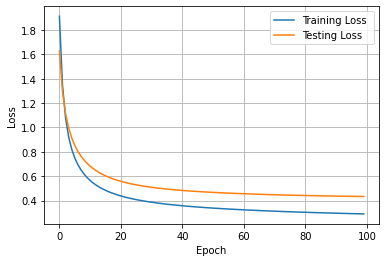

In [12]:
#Training
mlp.fit(X_train,y_train)

In [13]:
def predict(X):
    t_o2_list = []
    for i in range(0, len(X)):
        t_o1, t_o2 = mlp.drop_out_forward_test(X.iloc[i])
        t_o2_list.append(t_o2)
    
    y_pred = []
    for i in range(0, len(t_o2_list)):
      y_pred.append(t_o2_list[i].index(max(t_o2_list[i])))
    return y_pred

In [14]:
y_pred= predict(X_val)

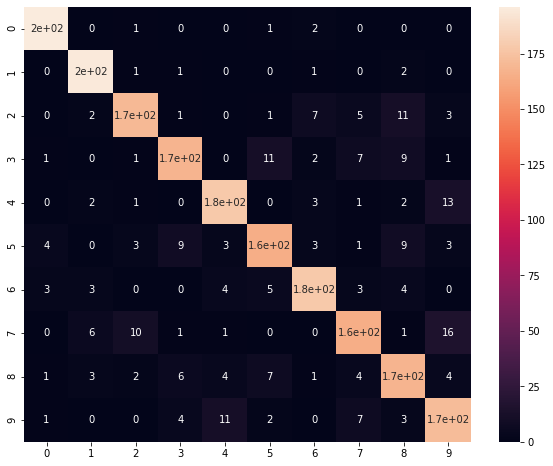

In [15]:
labels=list(set(y_val))
matrix =confusion_matrix(y_val,y_pred)  
cm_df = pd.DataFrame(matrix,labels,labels)                      
plt.figure(figsize=(10,8))  
sns.heatmap(cm_df, annot=True)

0.8775

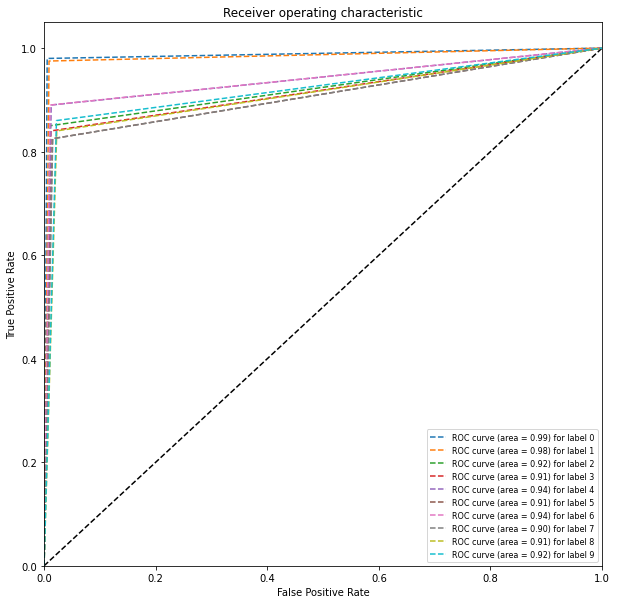

In [16]:
ROC(y_val, y_pred, 10)
accuracy_score(y_val, y_pred)

In [ ]:
#Save Model
mlp.saveModel("weights","q2_part2_relu_adam_l2_weights")